In [82]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [83]:
import warnings
warnings.filterwarnings("ignore")

In [87]:
hyper_df = pd.read_csv("reduced_rfe.csv")
hyper_df.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'num'], dtype='object')

In [88]:
X =hyper_df.drop(columns=['num'])
y=hyper_df['num']

In [89]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

In [91]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf

RandomForestClassifier(random_state=42)

In [92]:
# Grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Distributions for RandomizedSearchCV
from scipy.stats import randint
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2', None]
}

In [93]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print("GridSearchCV Best Params:", grid_search.best_params_)
print("GridSearchCV Best CV Accuracy:", grid_search.best_score_)

GridSearchCV Best Params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
GridSearchCV Best CV Accuracy: 0.6119897959183673


In [94]:
from sklearn.model_selection import RandomizedSearchCV

rand_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,        # number of random combinations to try
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)
rand_search.fit(X_train, y_train)

print("RandomizedSearchCV Best Params:", rand_search.best_params_)
print("RandomizedSearchCV Best CV Accuracy:", rand_search.best_score_)

RandomizedSearchCV Best Params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 107}
RandomizedSearchCV Best CV Accuracy: 0.6079931972789115


In [95]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

best_model = grid_search.best_estimator_  # or rand_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

Test Accuracy: 0.5245901639344263
Precision: 0.45090758205512305
Recall: 0.5245901639344263
F1 Score: 0.4794833581718828


In [96]:
import numpy as np
classes, counts = np.unique(y_pred, return_counts=True)
print(dict(zip(classes, counts)))

{np.int64(0): np.int64(37), np.int64(1): np.int64(8), np.int64(2): np.int64(7), np.int64(3): np.int64(9)}


In [97]:
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight
import numpy as np

# compute weights for each sample
weights = compute_sample_weight(class_weight='balanced', y=y_train)



xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    max_depth=6,
    n_estimators=300,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
# pass weights during fit
xgb_model.fit(X_train, y_train, sample_weight=weights)

print("✅ Upgraded XGBoost initialized with higher capacity and full CPU usage.")

✅ Upgraded XGBoost initialized with higher capacity and full CPU usage.


In [98]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

# Parameter distributions for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 10),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

# RandomizedSearchCV setup
rand_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring='accuracy',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("✅ RandomizedSearchCV ready.")

✅ RandomizedSearchCV ready.


In [99]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Fit RandomizedSearchCV
rand_search.fit(X_train, y_train)

# Best params & CV score
print("RandomizedSearchCV Best Params:", rand_search.best_params_)
print("Best CV Accuracy:", rand_search.best_score_)

# Evaluate on test set
best_xgb = rand_search.best_estimator_
y_pred = best_xgb.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
RandomizedSearchCV Best Params: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 150, 'reg_alpha': 0.1, 'reg_lambda': 1.5, 'subsample': 1.0}
Best CV Accuracy: 0.6077380952380953
Test Accuracy: 0.5409836065573771
Precision: 0.5024532844204975
Recall: 0.5409836065573771
F1 Score: 0.4947168442829002


In [100]:
from sklearn.model_selection import GridSearchCV

# Parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best params & CV score
print("GridSearchCV Best Params:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

# Evaluate on test set
best_xgb_grid = grid_search.best_estimator_
y_pred_grid = best_xgb_grid.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred_grid))
print("Precision:", precision_score(y_test, y_pred_grid, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_grid, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_grid, average='weighted'))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
GridSearchCV Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best CV Accuracy: 0.603656462585034
Test Accuracy: 0.5245901639344263
Precision: 0.4302878848460616
Recall: 0.5245901639344263
F1 Score: 0.4507167146409901


In [101]:
import pickle
import os

# Ensure folder exists
os.makedirs("models", exist_ok=True)

# Save the model
model_filename = "models/xgb_multiclass.pkl"
with open(model_filename, "wb") as f:
    pickle.dump(xgb_model, f)

print(f"✅ Model saved to {model_filename}")

✅ Model saved to models/xgb_multiclass.pkl


In [102]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Predict on test set
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)  # for AUC

# Compute metrics (handle multiclass)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')

# Prepare text
metrics_text = f"""
Model: XGBoost Multiclass
Accuracy: {accuracy:.4f}
Precision: {precision:.4f}
Recall: {recall:.4f}
F1 Score: {f1:.4f}
AUC: {auc:.4f}
"""

# Append to file
import os
os.makedirs("results", exist_ok=True)
with open("results/evaluation_metrics.txt", "a") as f:
    f.write(metrics_text + "\n")

print("✅ Metrics computed and appended to results/evaluation_metrics.txt")

✅ Metrics computed and appended to results/evaluation_metrics.txt


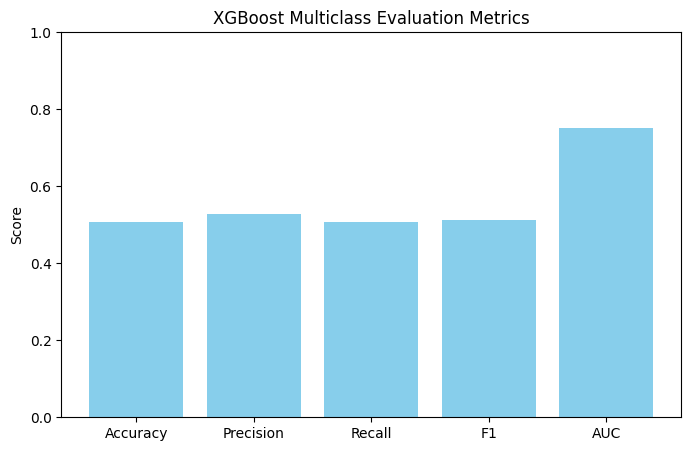

In [103]:
import matplotlib.pyplot as plt

metrics = {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1": f1, "AUC": auc}

plt.figure(figsize=(8,5))
plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.ylim(0,1)
plt.title("XGBoost Multiclass Evaluation Metrics")
plt.ylabel("Score")
plt.show()


In [104]:
!cat results/evaluation_metrics.txt

               Model  Accuracy  Precision   Recall       F1      AUC
Logisitic Regression  0.491803   0.401011 0.491803 0.408989 0.735441
       Decision Tree  0.540984   0.489343 0.540984 0.508525 0.675668
       Random Forest  0.459016   0.396423 0.459016 0.422945 0.726425
                 SVM  0.459016   0.375000 0.459016 0.388221 0.703522

# Clustering Evaluation Metrics
           Model  Silhouette  Calinski-Harabasz  Davies-Bouldin
KMeans_2clusters    0.539138         466.411628        0.774857
 Agglo_2clusters    0.539138         466.411628        0.774857
Model: XGBoost Multiclass
Accuracy: 0.5082
Precision: 0.5276
Recall: 0.5082
F1 Score: 0.5133
AUC: 0.7505



In [107]:
import pickle
import os

# Ensure models folder exists
os.makedirs("models", exist_ok=True)

# Save the best estimator from GridSearchCV
best_model = grid_search.best_estimator_
model_filename = "models/xgb_grid_best.pkl"

with open(model_filename, "wb") as f:
    pickle.dump(best_model, f)

print(f"✅ GridSearchCV best model saved to {model_filename}")

✅ GridSearchCV best model saved to models/xgb_grid_best.pkl
